## Test UNIQUE with Random Forest LogD model

In this Notebook, we showcase how to use UNIQUE to assess the uncertainty quantification methods for a random forest (RF) regressor trained to predict the LogD from public data automatically downlaoded from [ChEMBL](https://www.ebi.ac.uk/chembl/) database ([Query link](https://www.ebi.ac.uk/chembl/g/#browse/activities/filter/document_chembl_id%3ACHEMBL3301361%20AND%20standard_type%3A(%22LogD7.4%22)): `document_chemblid` = `CHEMBL3301361`, `standard_type` = `LogD7.4`).

As uncertainty quantification methods based on models, we derive the variance of the predictions from 100 trees for the RF.
- Regression Task
- UQ metrics:
    - Ensemble Variance (from the property model output)
    - TanimotoDistance (from Morgan fingerprints)

- Error model:
    - UniqueRandomForestRegressor

In [ ]:
import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import yaml
from rdkit.Chem import DataStructs, MolFromSmiles, Mol, rdFingerprintGenerator
from sklearn.ensemble import RandomForestRegressor

from unique.pipeline import Pipeline


# Set the project's directory
PROJECT_PATH = os.environ.get("PROJECT_PATH", os.path.abspath("")) # ALTERNATIVELY, REPLACE `os.path.abspath("")` WITH YOUR PATH TO THE SYNTHETIC EXAMPLE FOLDER
%cd $PROJECT_PATH



# Download data from CHEMBL and prepare UNIQUE input

In [2]:
try:
    from chembl_webresource_client.new_client import new_client
except ImportError as e:
    %pip install chembl-webresource-client
    from chembl_webresource_client.new_client import new_client


In [3]:
# Download data from ChEMBL
data_path = Path('./CHEMBL3301361.csv')

if data_path.is_file():
    df = pd.read_csv(data_path)
else:
    activity = new_client.activity
    bioactivities = activity.filter(document_chembl_id="CHEMBL3301361",
                                    standard_type="LogD7.4").only('molecule_chembl_id',
                                                                  'canonical_smiles',
                                                                  'standard_value')
    df = pd.DataFrame.from_records(bioactivities)
    # Save locally
    df.to_csv(data_path, index=False)

df.head()

,canonical_smiles,molecule_chembl_id,standard_value,value
0,COc1cc(F)ccc1-c1cncc(CNCC2CC2)n1,CHEMBL1778865,1.80,1.80
1,COc1cc(F)ccc1-c1cncc(CNCC2CC2)n1,CHEMBL1778865,1.80,1.80
2,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)[C@@H]1CCN(Cc2ccc(...,CHEMBL2010849,1.80,1.80
3,COc1cc2c(c(OC)c1OC)-c1ccc(O)cc1[C@@H](NC(C)=O)CC2,CHEMBL486504,1.81,1.81
4,N#Cc1cccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl...,CHEMBL2171044,1.81,1.81


## Generate fingerprints

In [4]:
def generate_fingerprints(molecules_list: List[Mol]) -> List:
    """Compute the corresponding Morgan fingerprints representation for input molecules.

    Args:
        molecules_list (List[Mol]):
            A list of `rdkit.Chem.Mol` objects (i.e., rdkit-compatible SMILES codes).
    
    Returns:
        A list of corresponding Morgan fingerprints.
    """
    fps = []

    # Check if we have any molecule objects
    if not molecules_list:
        return fps

    # generate count fingerprints output for sklearn
    for fp in rdFingerprintGenerator.GetCountFPs(molecules_list, fpType=rdFingerprintGenerator.MorganFP):
        cv = np.zeros((0,), np.int8)
        DataStructs.ConvertToNumpyArray(fp, cv)
        fps.append(cv)

    fps = [x.astype(bool).astype(int) for x in fps]
    return fps

In [5]:
# generate fingerprints
mols = [MolFromSmiles(i) for i in df.canonical_smiles]
fp = generate_fingerprints(mols)
df['fingerprints'] = [i.tolist() for i in fp]
df = df.drop(columns='value')
df.head()

,canonical_smiles,molecule_chembl_id,standard_value,fingerprints
0,COc1cc(F)ccc1-c1cncc(CNCC2CC2)n1,CHEMBL1778865,1.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,COc1cc(F)ccc1-c1cncc(CNCC2CC2)n1,CHEMBL1778865,1.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)[C@@H]1CCN(Cc2ccc(...,CHEMBL2010849,1.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COc1cc2c(c(OC)c1OC)-c1ccc(O)cc1[C@@H](NC(C)=O)CC2,CHEMBL486504,1.81,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,N#Cc1cccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl...,CHEMBL2171044,1.81,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Create training, calibration, and test sets

In [6]:
import random
seed = 1
x = list(range(df.shape[0]))
random.Random(seed).shuffle(x)
perc_train = 0.5
perc_calib = 0.3
limit_train = int(len(x) * perc_train)
limit_calib = int(len(x) * perc_calib)
index_train = x[:limit_train]
index_calib = x[limit_train:(limit_train + limit_calib)]
index_test = x[(limit_train + limit_calib):]

df['which_set'] = None
df.loc[df.index[index_train], 'which_set'] = 'TRAIN'
df.loc[df.index[index_calib], 'which_set'] = 'CALIBRATION'
df.loc[df.index[index_test], 'which_set'] = 'TEST'

df.which_set.value_counts() / df.which_set.shape[0] * 100

which_set
TRAIN          49.988098
CALIBRATION    29.992859
TEST           20.019043
Name: count, dtype: float64

In [7]:
X_train = np.stack(df[df['which_set'] == 'TRAIN']['fingerprints'].tolist())
Y_train = df[df['which_set'] == 'TRAIN']['standard_value'].values

X_calib = np.stack(df[df['which_set'] == 'CALIBRATION']['fingerprints'].tolist())
Y_calib = df[df['which_set'] == 'CALIBRATION']['standard_value'].values

X_test = np.stack(df[df['which_set'] == 'TEST']['fingerprints'].tolist())
Y_test = df[df['which_set'] == 'TEST']['standard_value'].values

## Define RF Regressor and fit with training set

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rmse = mean_squared_error(test_labels, predictions, squared=False)
    print(f'MAE: {mean_absolute_error(test_labels, predictions):.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2: {r2_score(test_labels, predictions):.4f}')

In [9]:
# fitting in ~ 1 minutes
best_parameter_set = {'n_estimators': 200,
                      'min_samples_split': 2,
                      'min_samples_leaf': 2,
                      'max_depth': None,
                     'random_state': 42}


regr = RandomForestRegressor(**best_parameter_set)
regr.fit(X_train, Y_train)
print('Evaluation on calibration set:')
evaluate(regr, X_calib, Y_calib)
print('Evaluation on test set:')
evaluate(regr, X_test, Y_test)

Evaluation on calibration set:
MAE: 0.6667
RMSE: 0.8729
R2: 0.4693
Evaluation on test set:
MAE: 0.6586
RMSE: 0.8740
R2: 0.4527


## Predict on the entire data se

In [10]:
Xall = np.stack(df['fingerprints'].tolist())
predictions = regr.predict(Xall)
df['predictions'] = predictions
df.head()

,canonical_smiles,molecule_chembl_id,standard_value,fingerprints,which_set,predictions
0,COc1cc(F)ccc1-c1cncc(CNCC2CC2)n1,CHEMBL1778865,1.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",TRAIN,1.889113
1,COc1cc(F)ccc1-c1cncc(CNCC2CC2)n1,CHEMBL1778865,1.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",TRAIN,1.889113
2,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)[C@@H]1CCN(Cc2ccc(...,CHEMBL2010849,1.80,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",CALIBRATION,2.633078
3,COc1cc2c(c(OC)c1OC)-c1ccc(O)cc1[C@@H](NC(C)=O)CC2,CHEMBL486504,1.81,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",TEST,0.788626
4,N#Cc1cccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl...,CHEMBL2171044,1.81,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",TRAIN,2.029591


### Collect predictions for variance estimation

In [11]:
# collect predictions
numberTrees = 100
collect = []
for tree in range(numberTrees):
    collect.append(regr.estimators_[tree].predict(Xall))

# reshape predictions in order to obtain a vector of predictions for each sample
tree_num = 0
collect_all = []
for sample in range(df.shape[0]):
    predictions_trees = []
    for tree in collect:
        predictions_trees.append(tree[sample])
    collect_all.append(predictions_trees)

## Prepare UNIQUE input

In [12]:
# store it in the original dataframe
df['ensemble_input_type'] = collect_all
df = df.rename(columns={'ensemble_input_type': 'rf_predictions'})
df['variance'] = df['rf_predictions'].map(lambda x: np.var(x))
df.to_csv('./LogD_unique_input_data.csv')

In [13]:
df = pd.read_csv("./LogD_unique_input_data.csv")

## UNIQUE Pipeline

To evaluate the UQ methods of interest, including an additional set of UQ methods generated by the UNIQUE pipeline, you can run the `fit()` method of the pipeline. This will allow you to assess their performance using three main UQ evaluation types: Ranking, Proper scoring rules, and Calibration curves.

The summary tables provide scores for each UQ method based on a set of UQ evaluation metrics that are indicative of each evaluation type. The UQ method with the highest score is highlighted in green, indicating it as the best performing method.

Following the summary tables, you will find individual plots showcasing the performance of the best UQ methods.

Additionally, you can explore the summary plots generated for all the evaluated UQ methods, providing a comprehensive overview of their performance.

In [14]:
def overwrite_paths(yaml_file: str, project_path: str, input_data_file: str = "LogD_unique_input_data.csv"):
	"""Given a yaml UNIQUE config file, overwrite the `data_path` and `output_path` fields."""
	# Use ruamel.yaml to preserve comments
	from ruamel.yaml import YAML
	yaml = YAML()

	# Read
	with open(yaml_file, "r") as f:
		# If you want the equivalent of yaml.safe_load use `typ="safe"`
		config = yaml.load(f) # defaults to `typ="rt"` (round-trip) argument. 

	# Overwrite
	config["data_path"] = os.path.join(project_path, input_data_file)
	config["output_path"] = os.path.join(project_path, "output")

	# Save
	with open(yaml_file, "w") as f:
		yaml.dump(config, f)

[2024-08-06 16:10:42] | [UNIQUE - INFO]: ************************ UNIQUE - INITIALIZING PIPELINE ************************
[2024-08-06 16:10:42] | [UNIQUE - INFO]: Loaded Pipeline configuration from: 'logD_RFmfp_unique_input_config.yaml'
[2024-08-06 16:10:42] | [UNIQUE - INFO]: Loading data from 'LogD_unique_input_data.csv'...
[2024-08-06 16:10:42] | [UNIQUE - INFO]: Dataset with 4201 entries correctly loaded.
[2024-08-06 16:10:42] | [UNIQUE - INFO]: UQ inputs initialization...
[2024-08-06 16:13:16] | [UNIQUE - INFO]: UQ inputs summary: 
                                             1. [Data-Based Feature] Column: 'fingerprints' | UQ methods to compute: Tanimoto Distance
                                             2. [Model-Based Feature] Column: 'variance' | UQ methods to compute: Ensemble Variance
[2024-08-06 16:13:16] | [UNIQUE - INFO]: Selected error model(s): 
                                             1. UniqueRandomForestRegressor
[2024-08-06 16:13:16] | [UNIQUE - INFO]: ******

,UQ Method,Subset,AUC Difference: UQ vs. True Error,Spearman Correlation,Decreasing Coefficient,Increasing Coefficient,Performance Drop: High UQ vs. Low UQ (10-Bins),Performance Drop: All vs. Low UQ (10-Bins),Performance Drop: All vs. Low UQ (3-Bins),Performance Drop: High UQ vs. Low UQ (3-Bins)
0,TanimotoDistance[fingerprints],TEST,0.203,0.329,4.453,0.153,2.720,1.608,1.449,2.013
1,EnsembleVariance[variance],TEST,0.196,0.348,4.295,0.189,2.845,1.918,1.590,2.092
2,"Diff5NN[TanimotoDistance[fingerprints], EnsembleVariance[variance]]",TEST,0.253,0.229,4.325,0.632,1.691,1.157,1.227,1.557
3,"Diff5NN[TanimotoDistance[fingerprints], predictions]",TEST,0.322,0.019,2.774,1.890,1.044,1.047,1.025,1.094
4,Dist2Var[TanimotoDistance[fingerprints]],TEST,0.203,0.329,4.453,0.153,2.720,1.608,1.449,2.013
5,SumOfVariances[Dist2Var[TanimotoDistance[fingerprints]]],TEST,0.187,0.364,4.395,0.035,2.886,1.808,1.560,2.111
6,UniqueRandomForestRegressor[fingerprints+UQmetrics+predictions](l1),TEST,0.186,0.375,4.432,0.305,2.995,1.860,1.598,2.238
7,UniqueRandomForestRegressor[UQmetrics+predictions](l1),TEST,0.189,0.360,4.407,0.148,3.072,1.867,1.544,2.104
8,UniqueRandomForestRegressor[transformedUQmetrics+predictions](l1),TEST,0.191,0.356,4.407,0.132,2.764,1.682,1.546,2.139


,UQ Method,Subset,MACE,RMSCE
0,EnsembleVariance[variance],TEST,0.146,0.183
1,Dist2Var[TanimotoDistance[fingerprints]],TEST,0.138,0.173
2,SumOfVariances[Dist2Var[TanimotoDistance[fingerprints]]],TEST,0.073,0.089
3,UniqueRandomForestRegressor[fingerprints+UQmetrics+predictions](l1),TEST,0.167,0.206
4,UniqueRandomForestRegressor[UQmetrics+predictions](l1),TEST,0.166,0.205
5,UniqueRandomForestRegressor[transformedUQmetrics+predictions](l1),TEST,0.165,0.203


,UQ Method,Subset,NLL,IntervalScore,CheckScore,CRPS
0,EnsembleVariance[variance],TEST,1.278,2.353,0.236,0.468
1,Dist2Var[TanimotoDistance[fingerprints]],TEST,1.225,2.360,0.238,0.471
2,SumOfVariances[Dist2Var[TanimotoDistance[fingerprints]]],TEST,1.304,2.512,0.246,0.487
3,UniqueRandomForestRegressor[fingerprints+UQmetrics+predictions](l1),TEST,1.212,2.345,0.236,0.468
4,UniqueRandomForestRegressor[UQmetrics+predictions](l1),TEST,1.220,2.349,0.236,0.468
5,UniqueRandomForestRegressor[transformedUQmetrics+predictions](l1),TEST,1.208,2.336,0.236,0.467


[2024-08-06 16:15:20] | [UNIQUE - INFO]: Summary evaluation tables saved to: .../LogD_public/output/summary.
[2024-08-06 16:15:35] | [UNIQUE - INFO]: Generating summary plots...
[2024-08-06 16:15:48] | [UNIQUE - INFO]: Summary plots saved to: .../LogD_public/output/summary.
[2024-08-06 16:15:48] | [UNIQUE - INFO]: Summary of best UQ method for each UQ evaluation type:
                                             1. [TEST] RankingBasedEvaluation: UniqueRandomForestRegressor[fingerprints+UQmetrics+predictions](l1)
                                             2. [TEST] CalibrationBasedEvaluation: SumOfVariances[Dist2Var[TanimotoDistance[fingerprints]]]
                                             3. [TEST] ProperScoringRulesEvaluation: UniqueRandomForestRegressor[transformedUQmetrics+predictions](l1)
[2024-08-06 16:15:48] | [UNIQUE - INFO]: ********************************* UNIQUE - END *********************************
[2024-08-06 16:15:48] | [UNIQUE - INFO]: Time elapsed: 00h:02m:32s


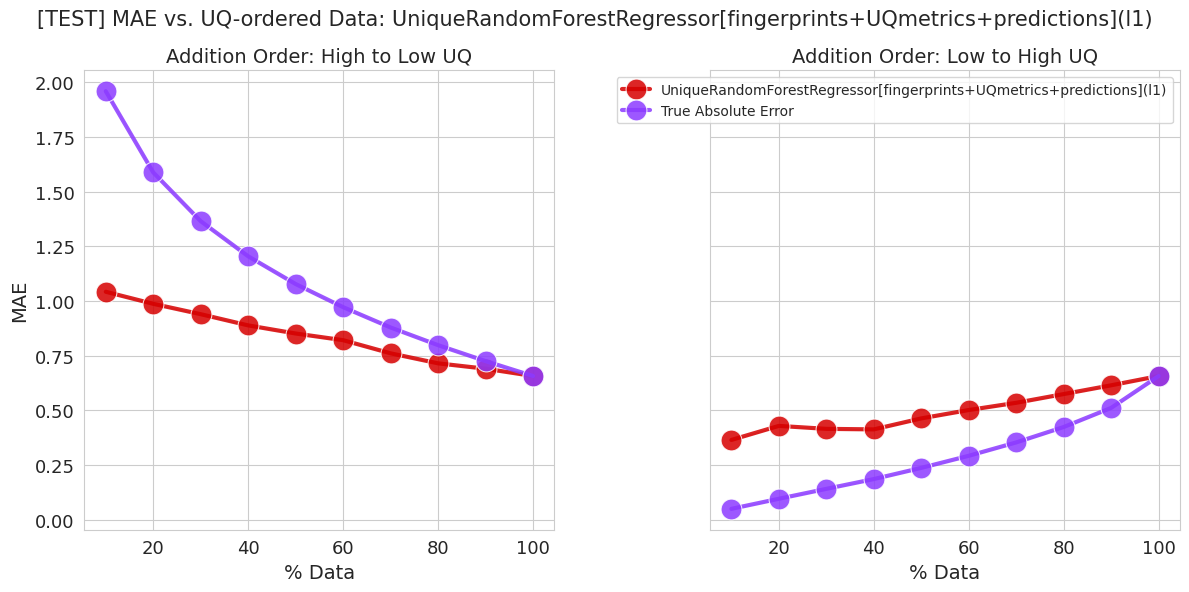

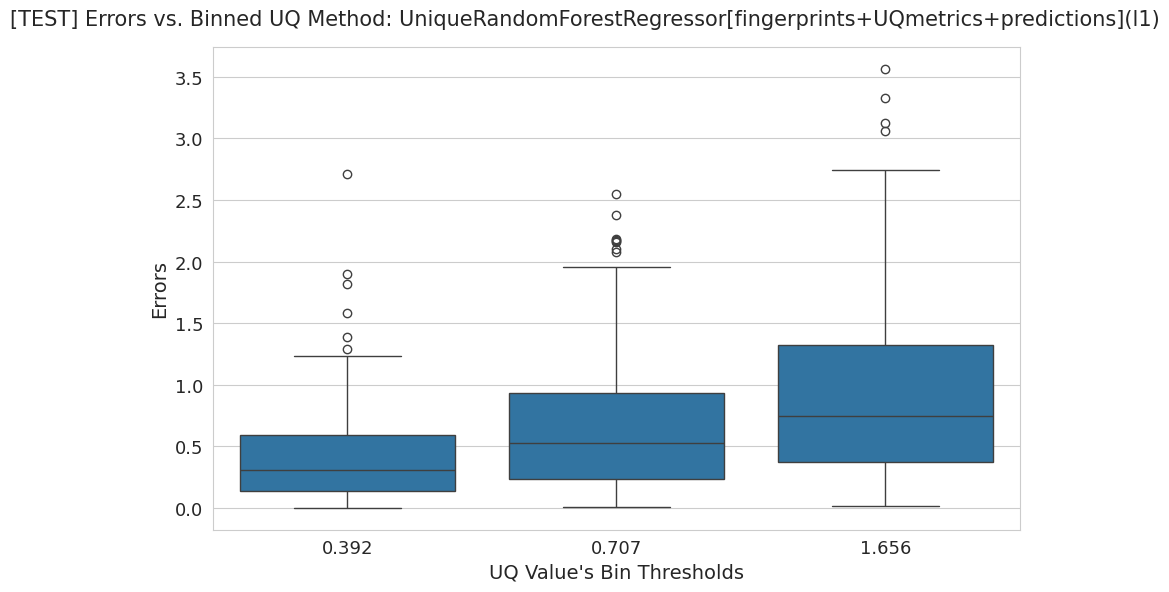

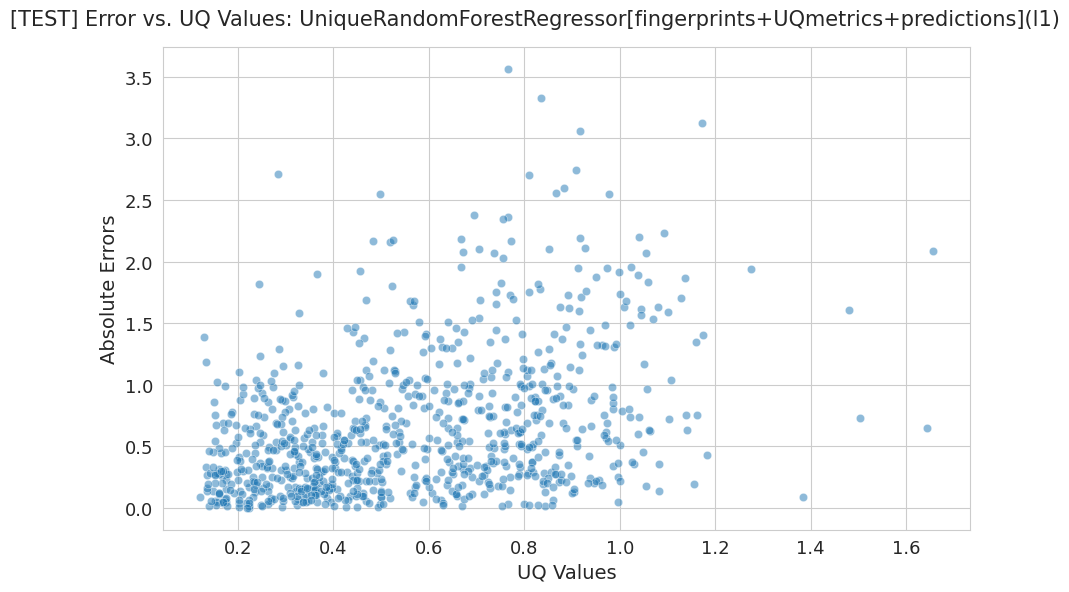

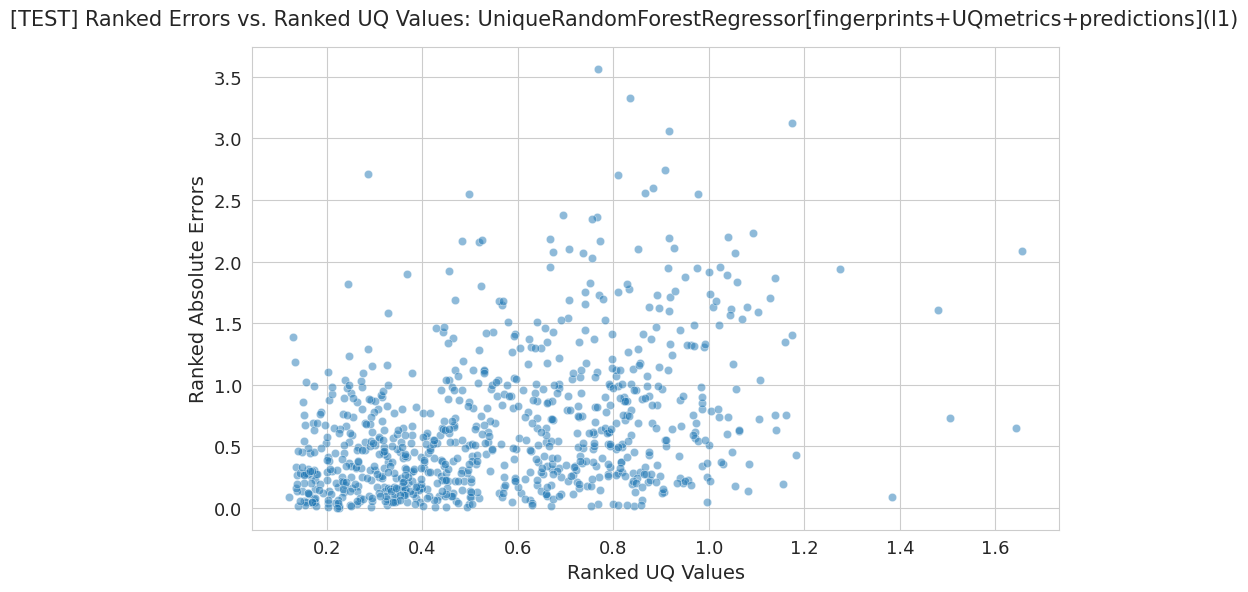

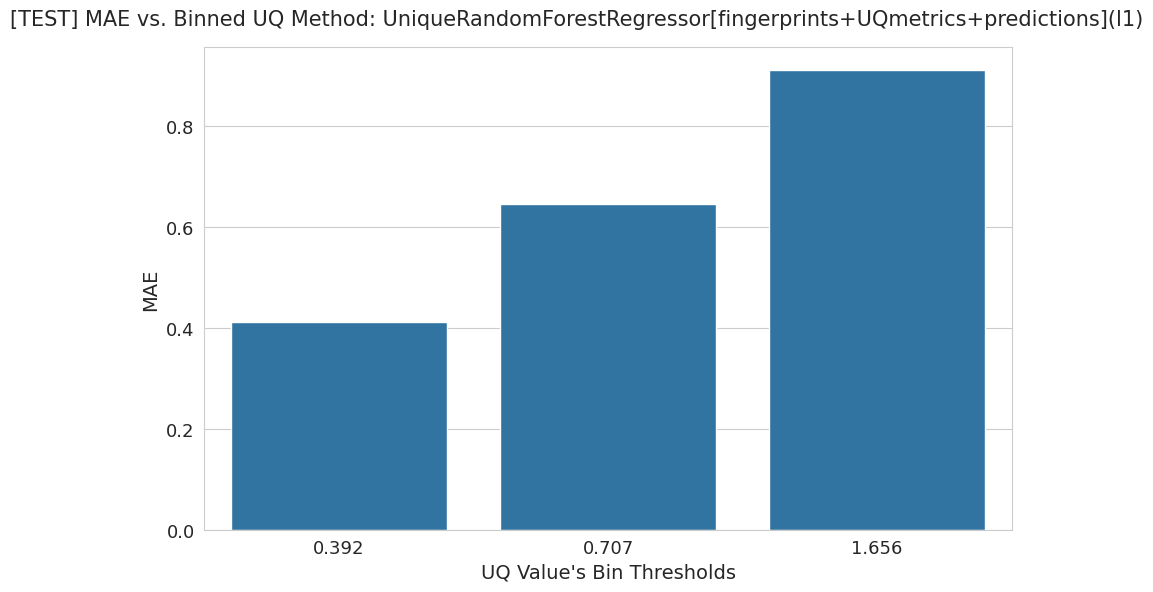

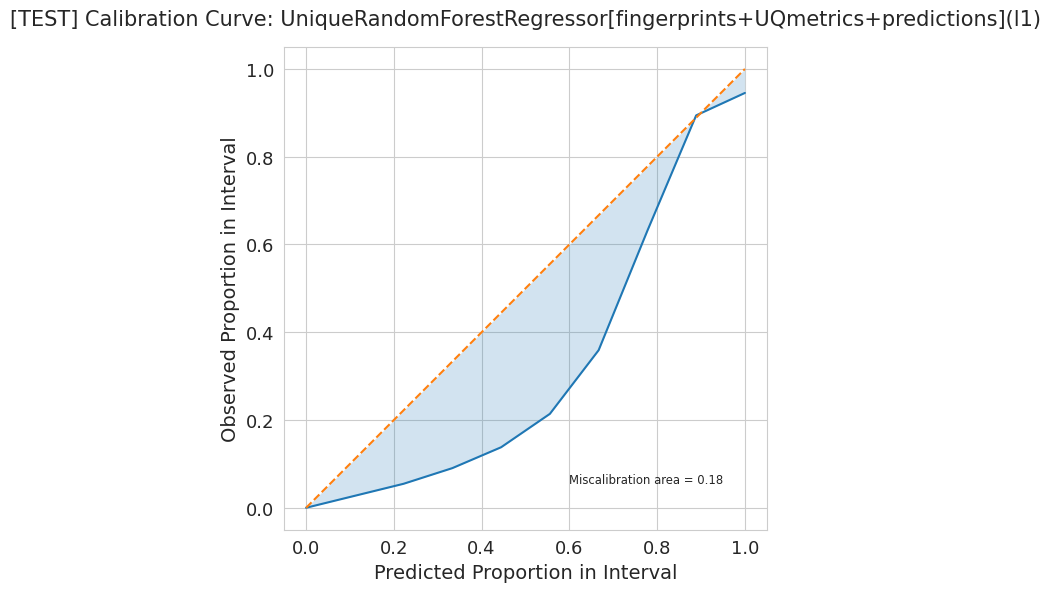

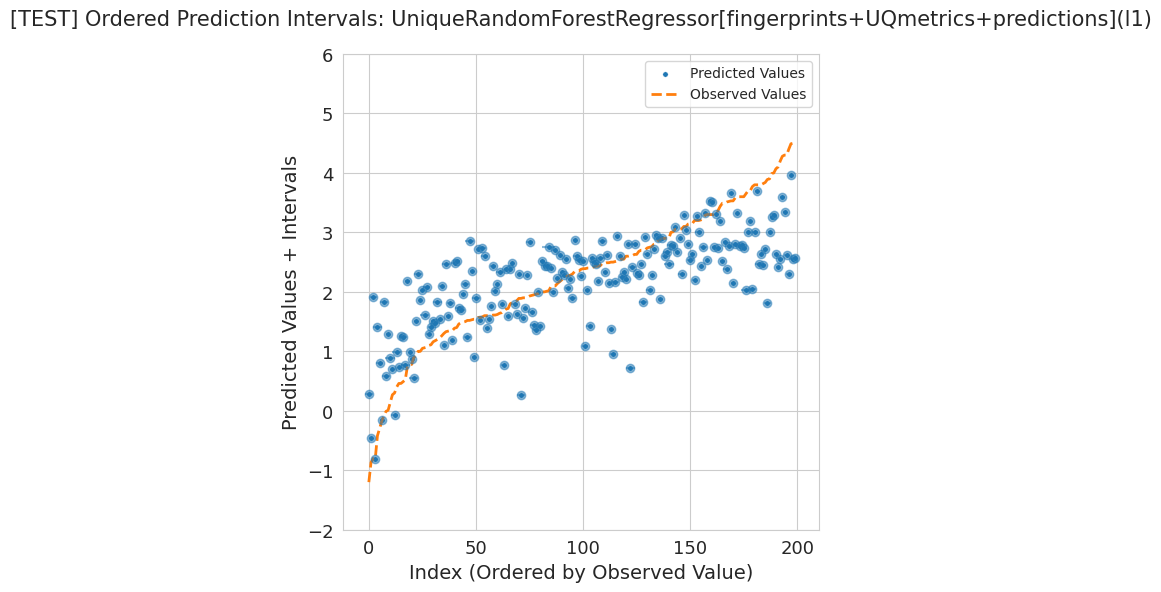

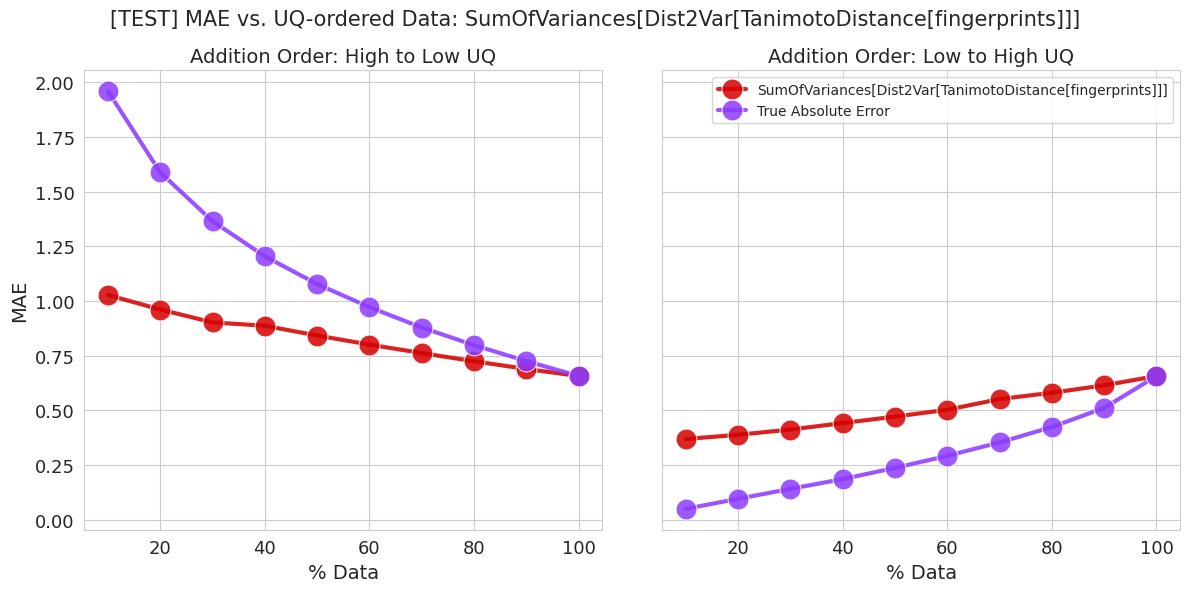

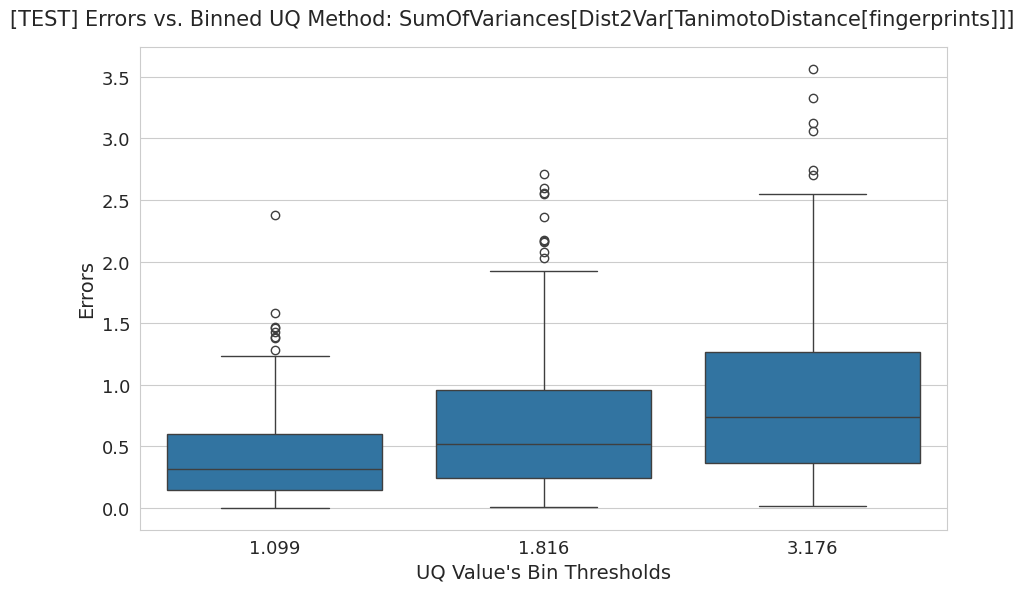

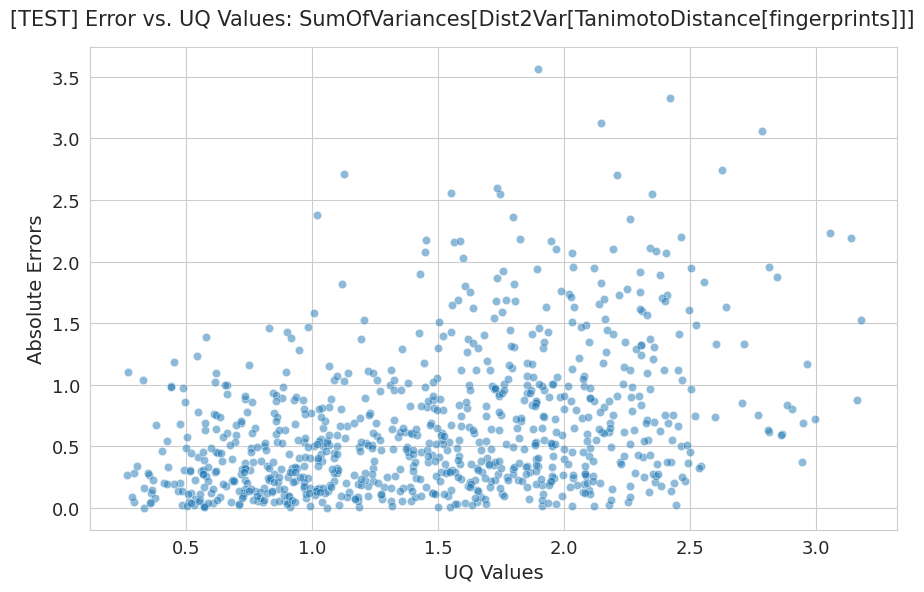

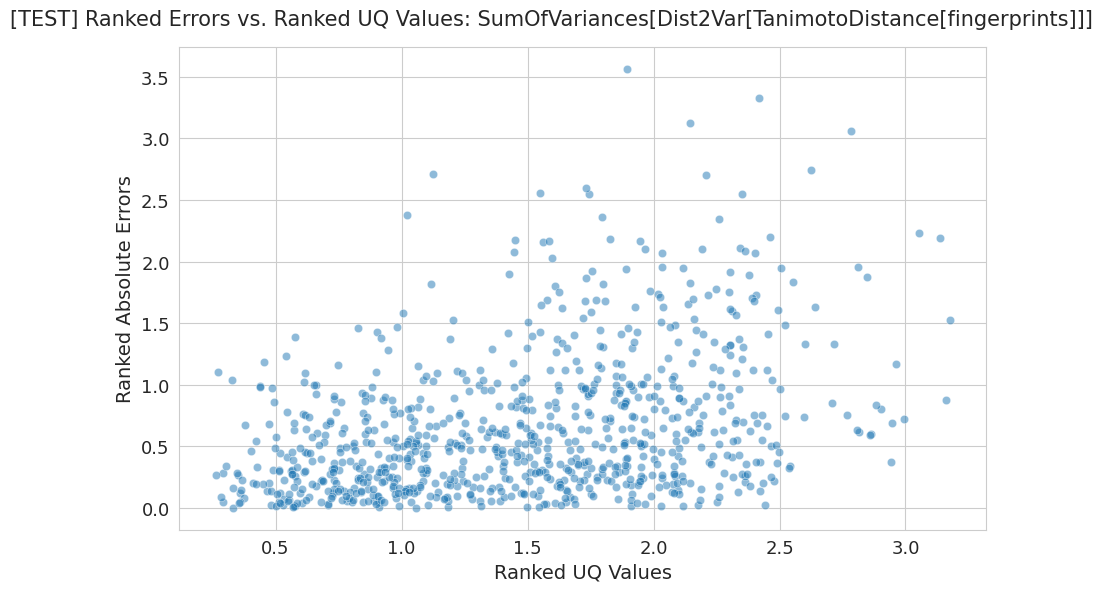

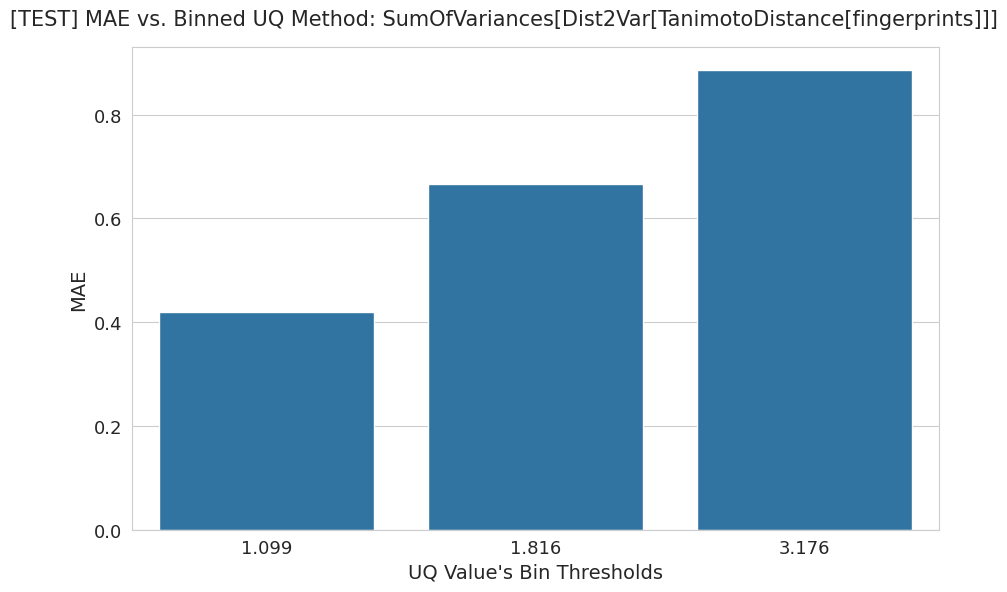

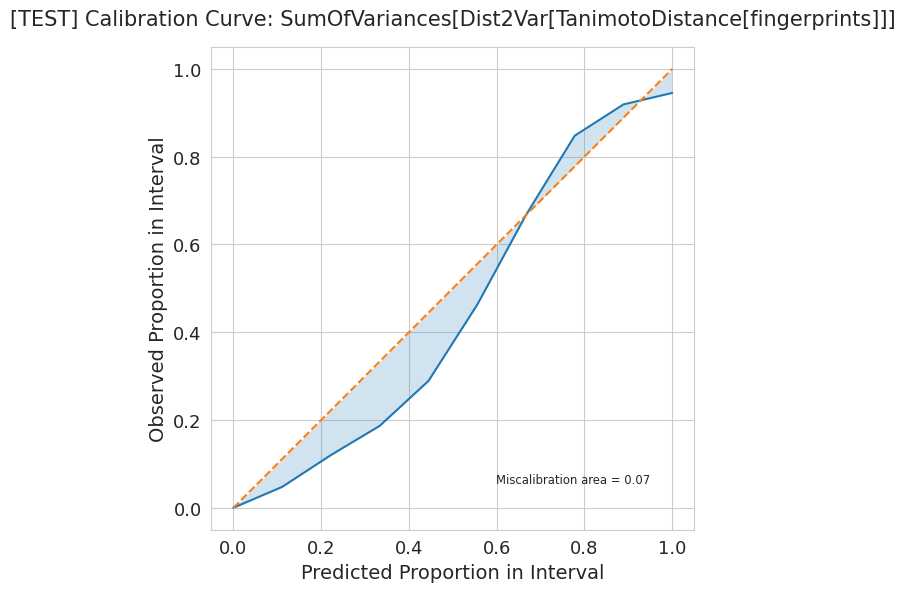

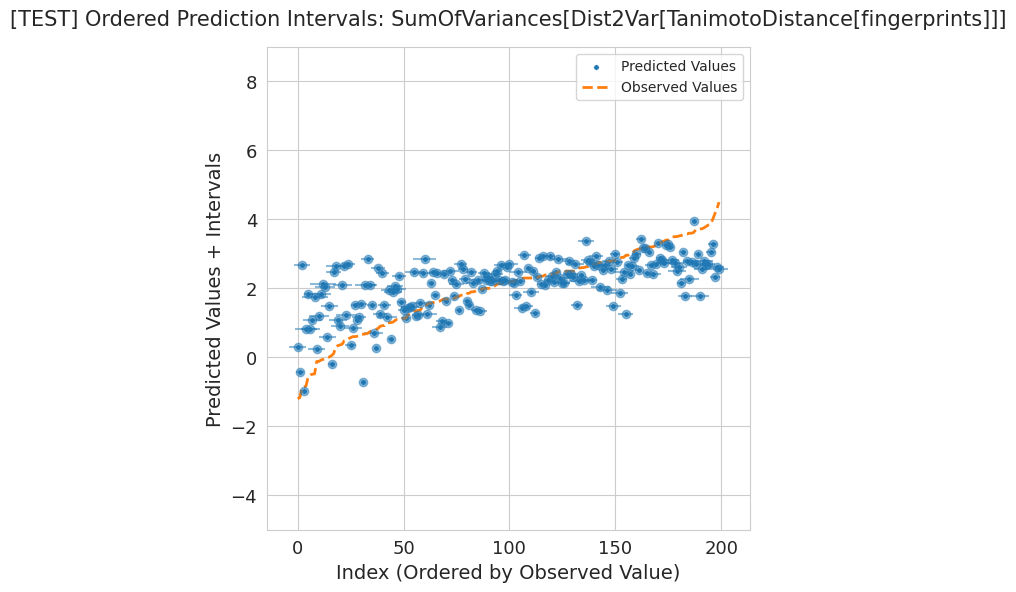

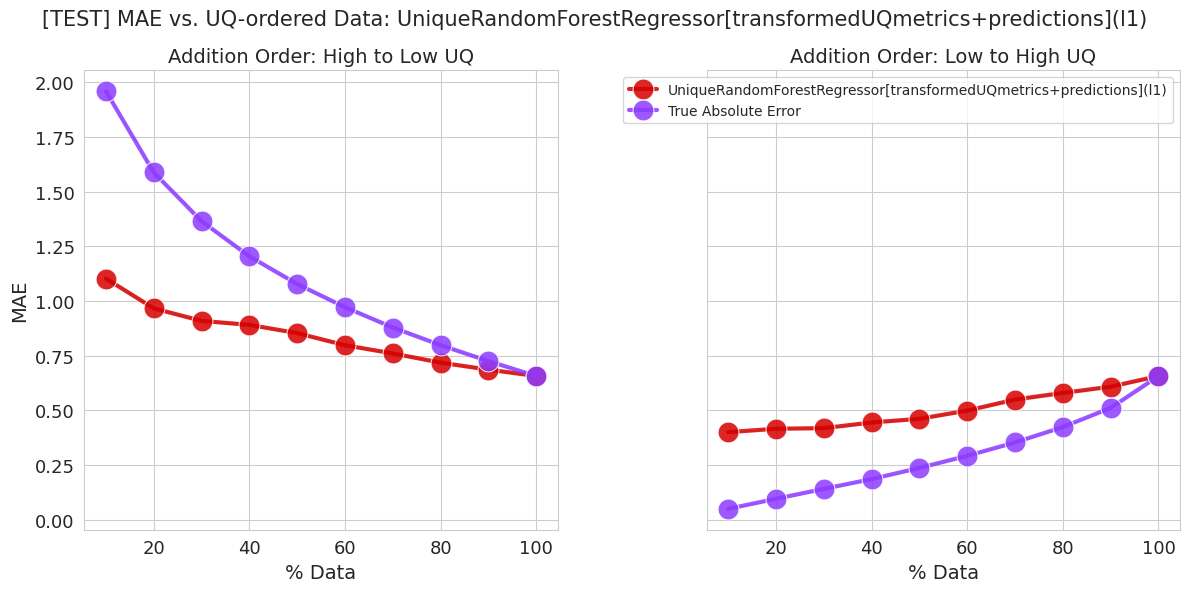

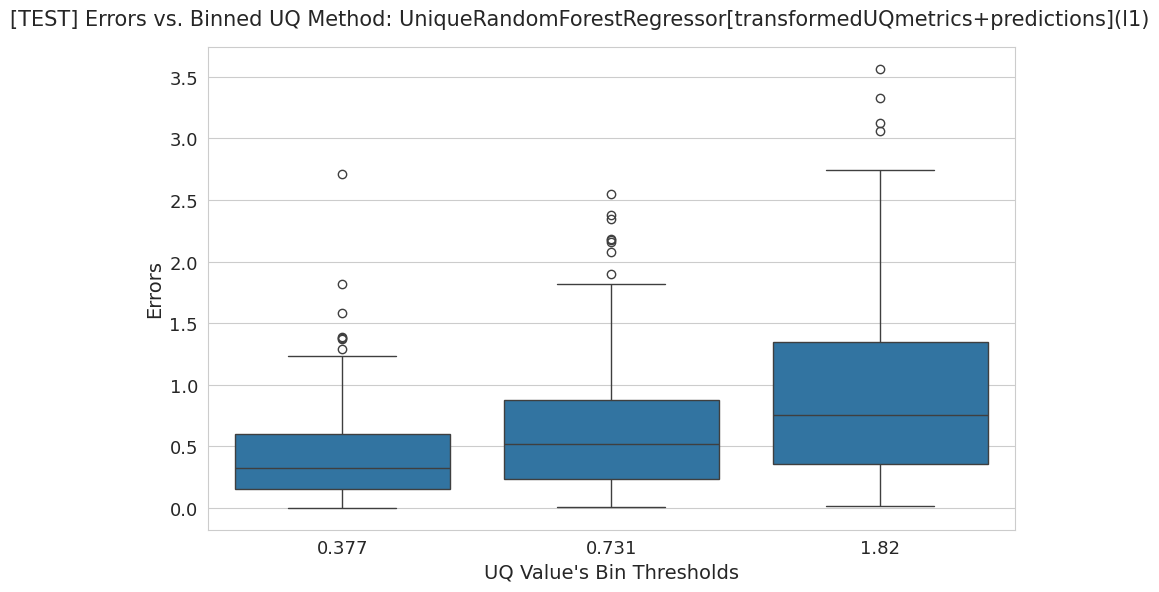

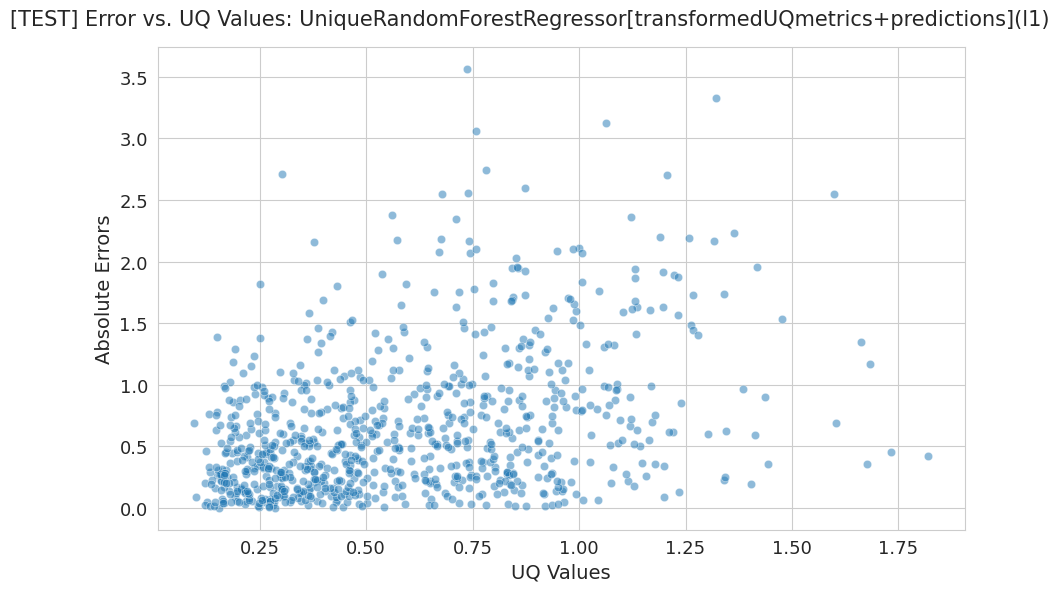

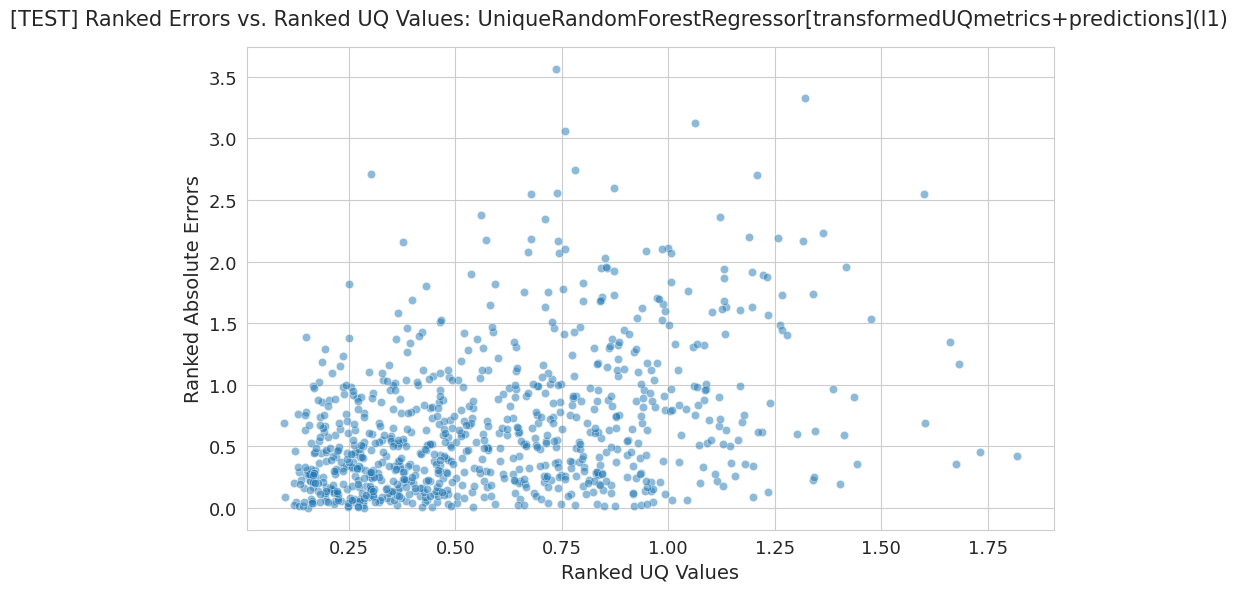

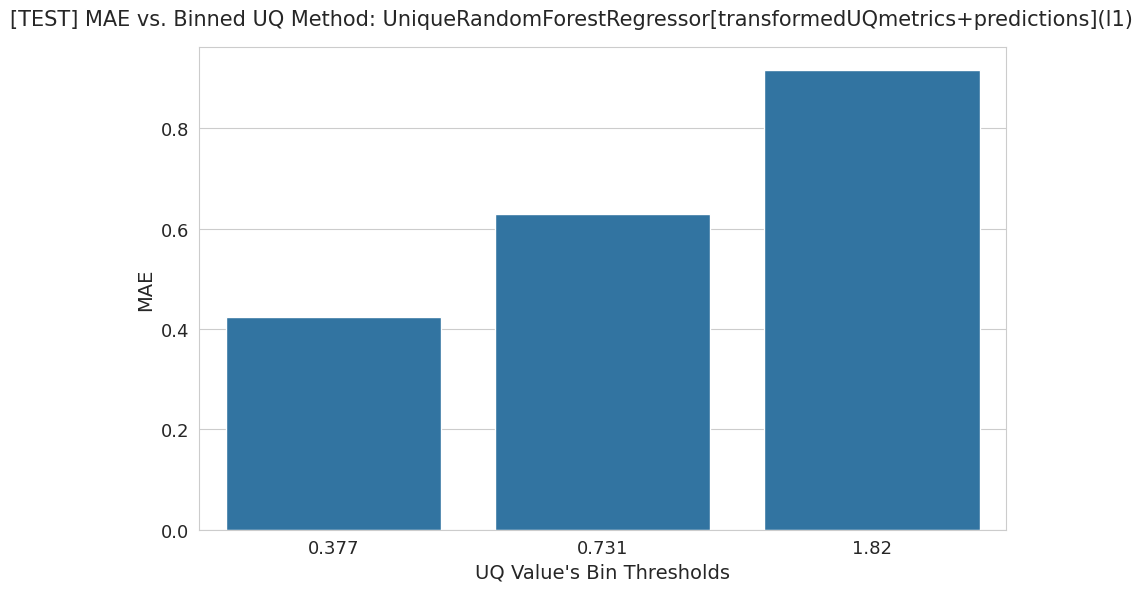

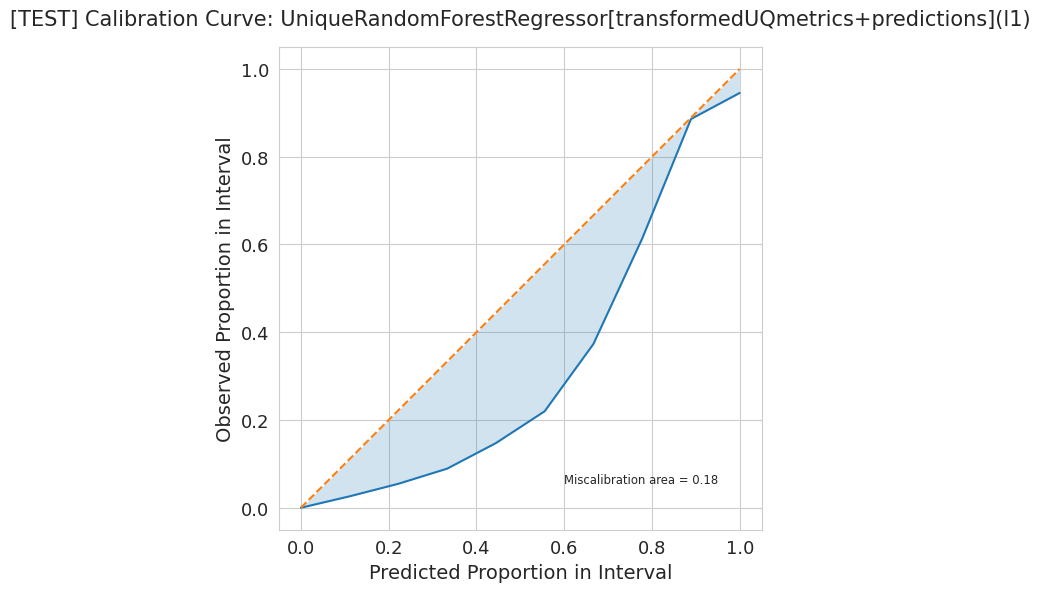

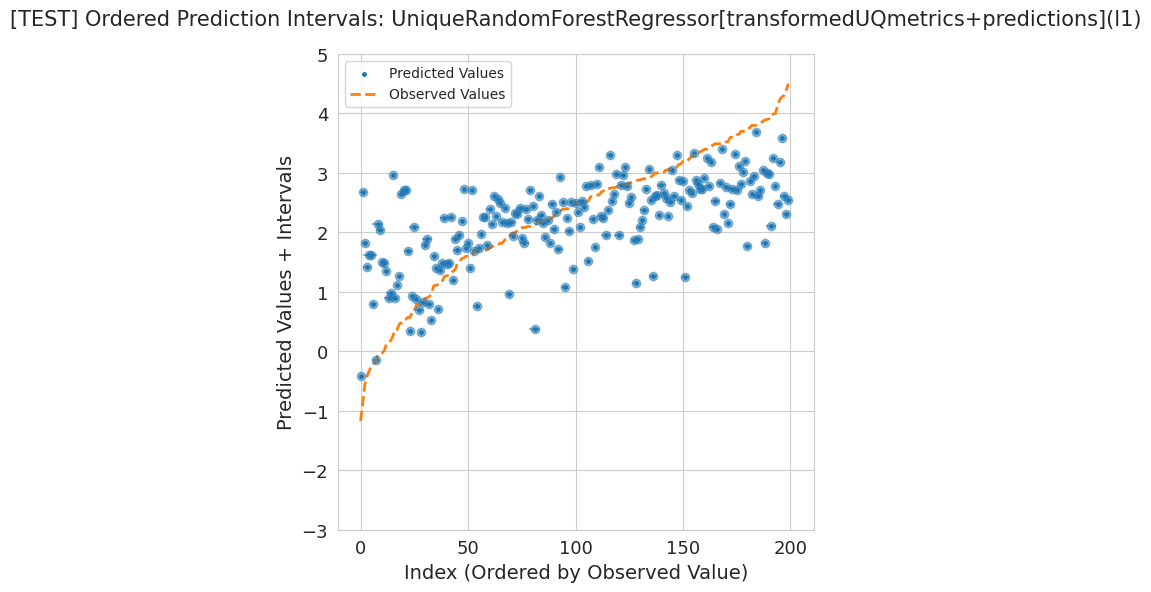

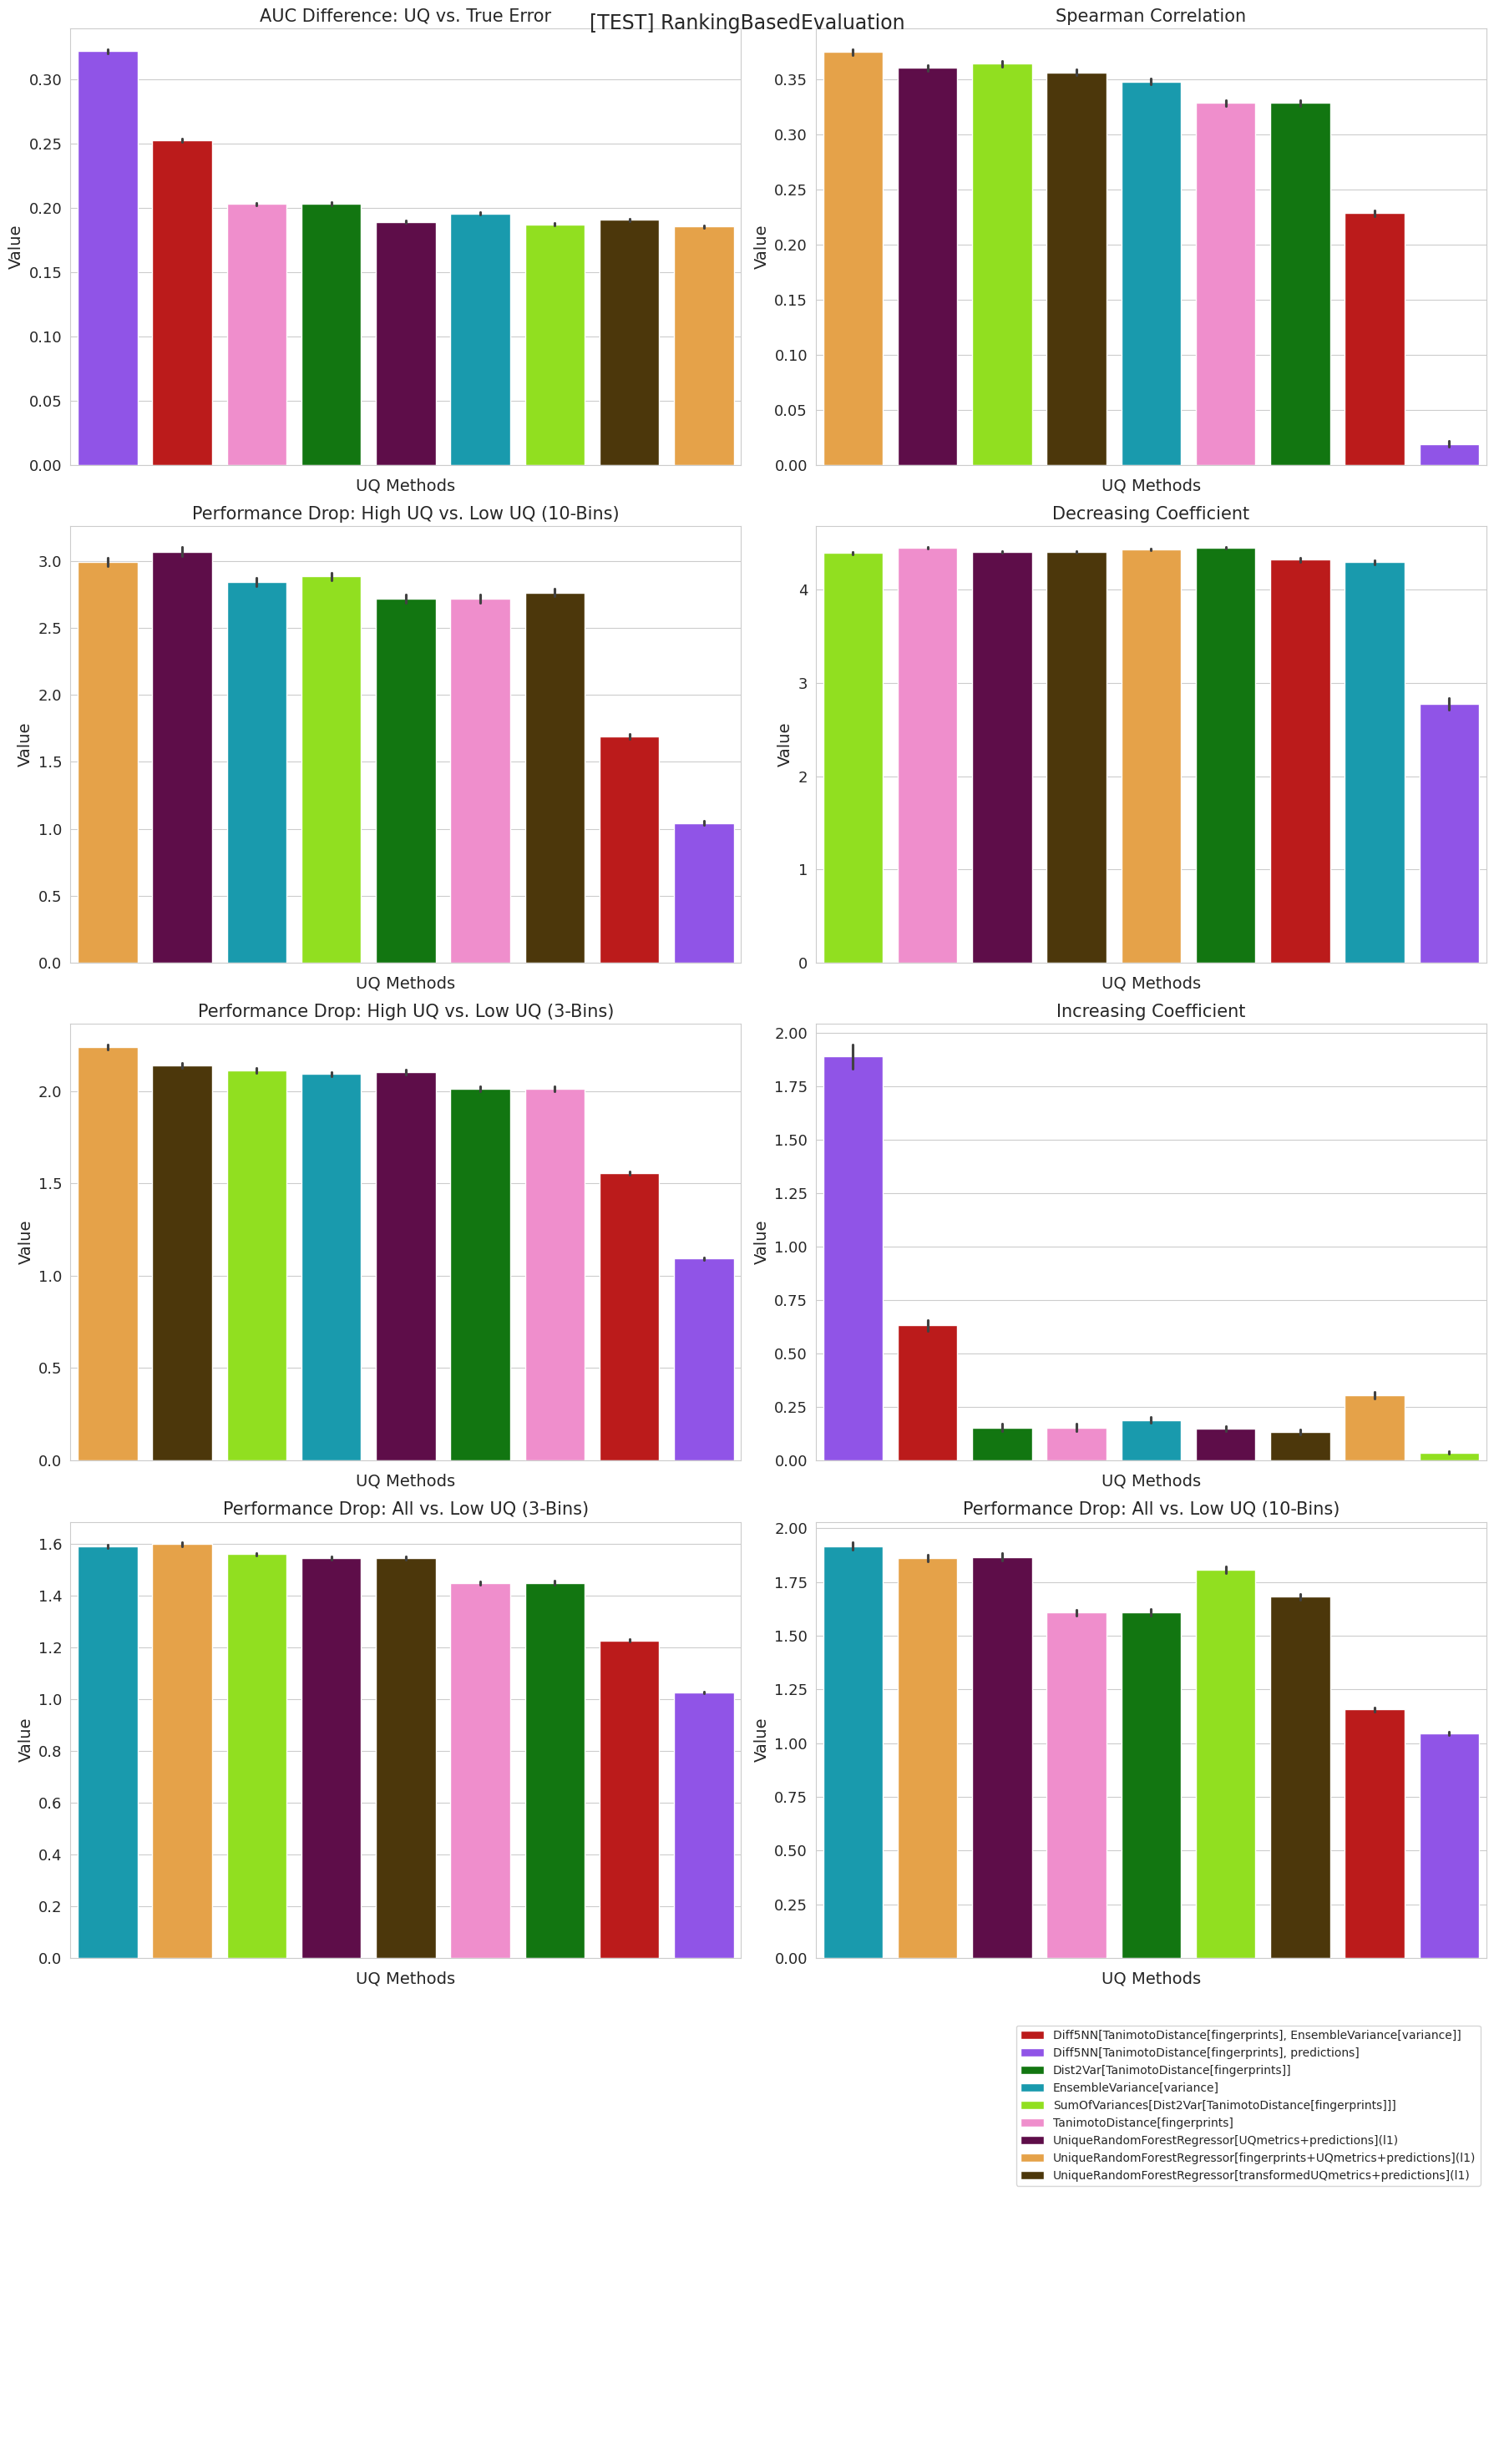

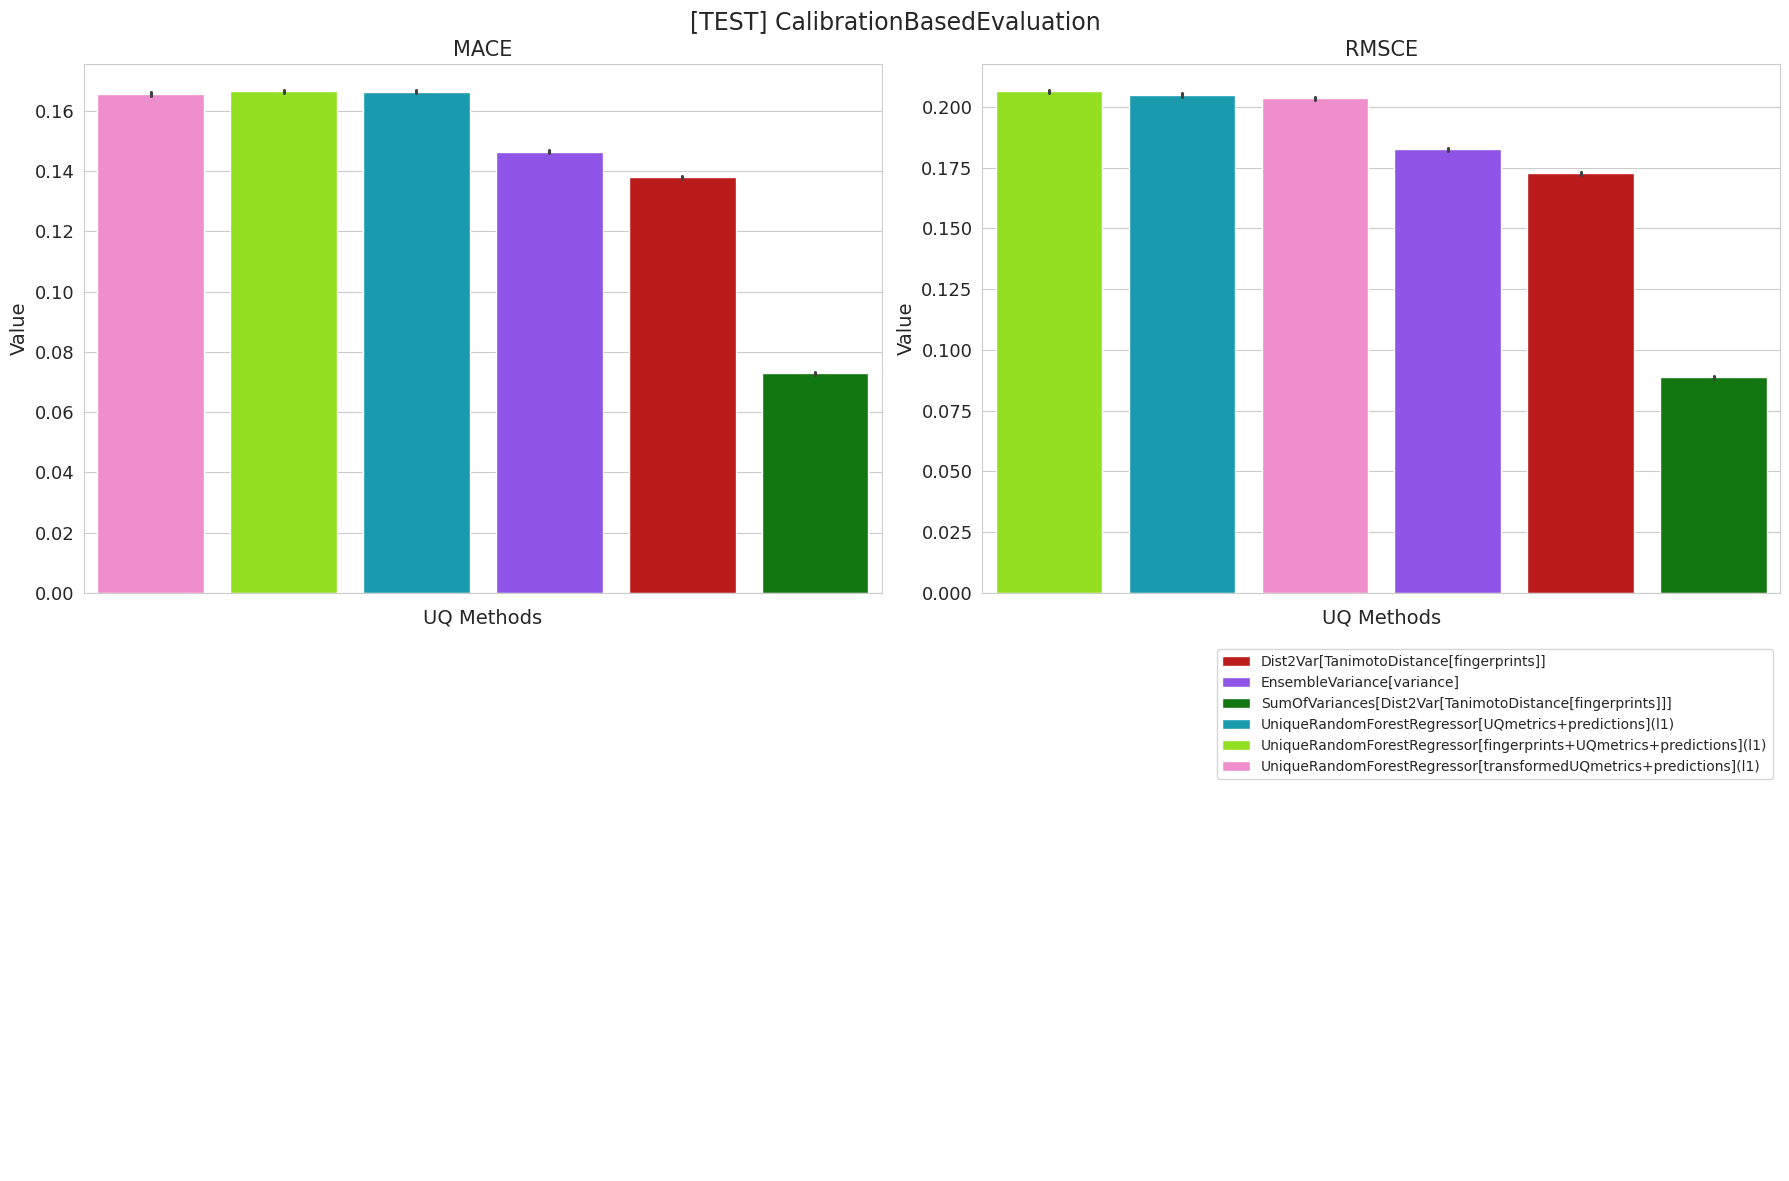

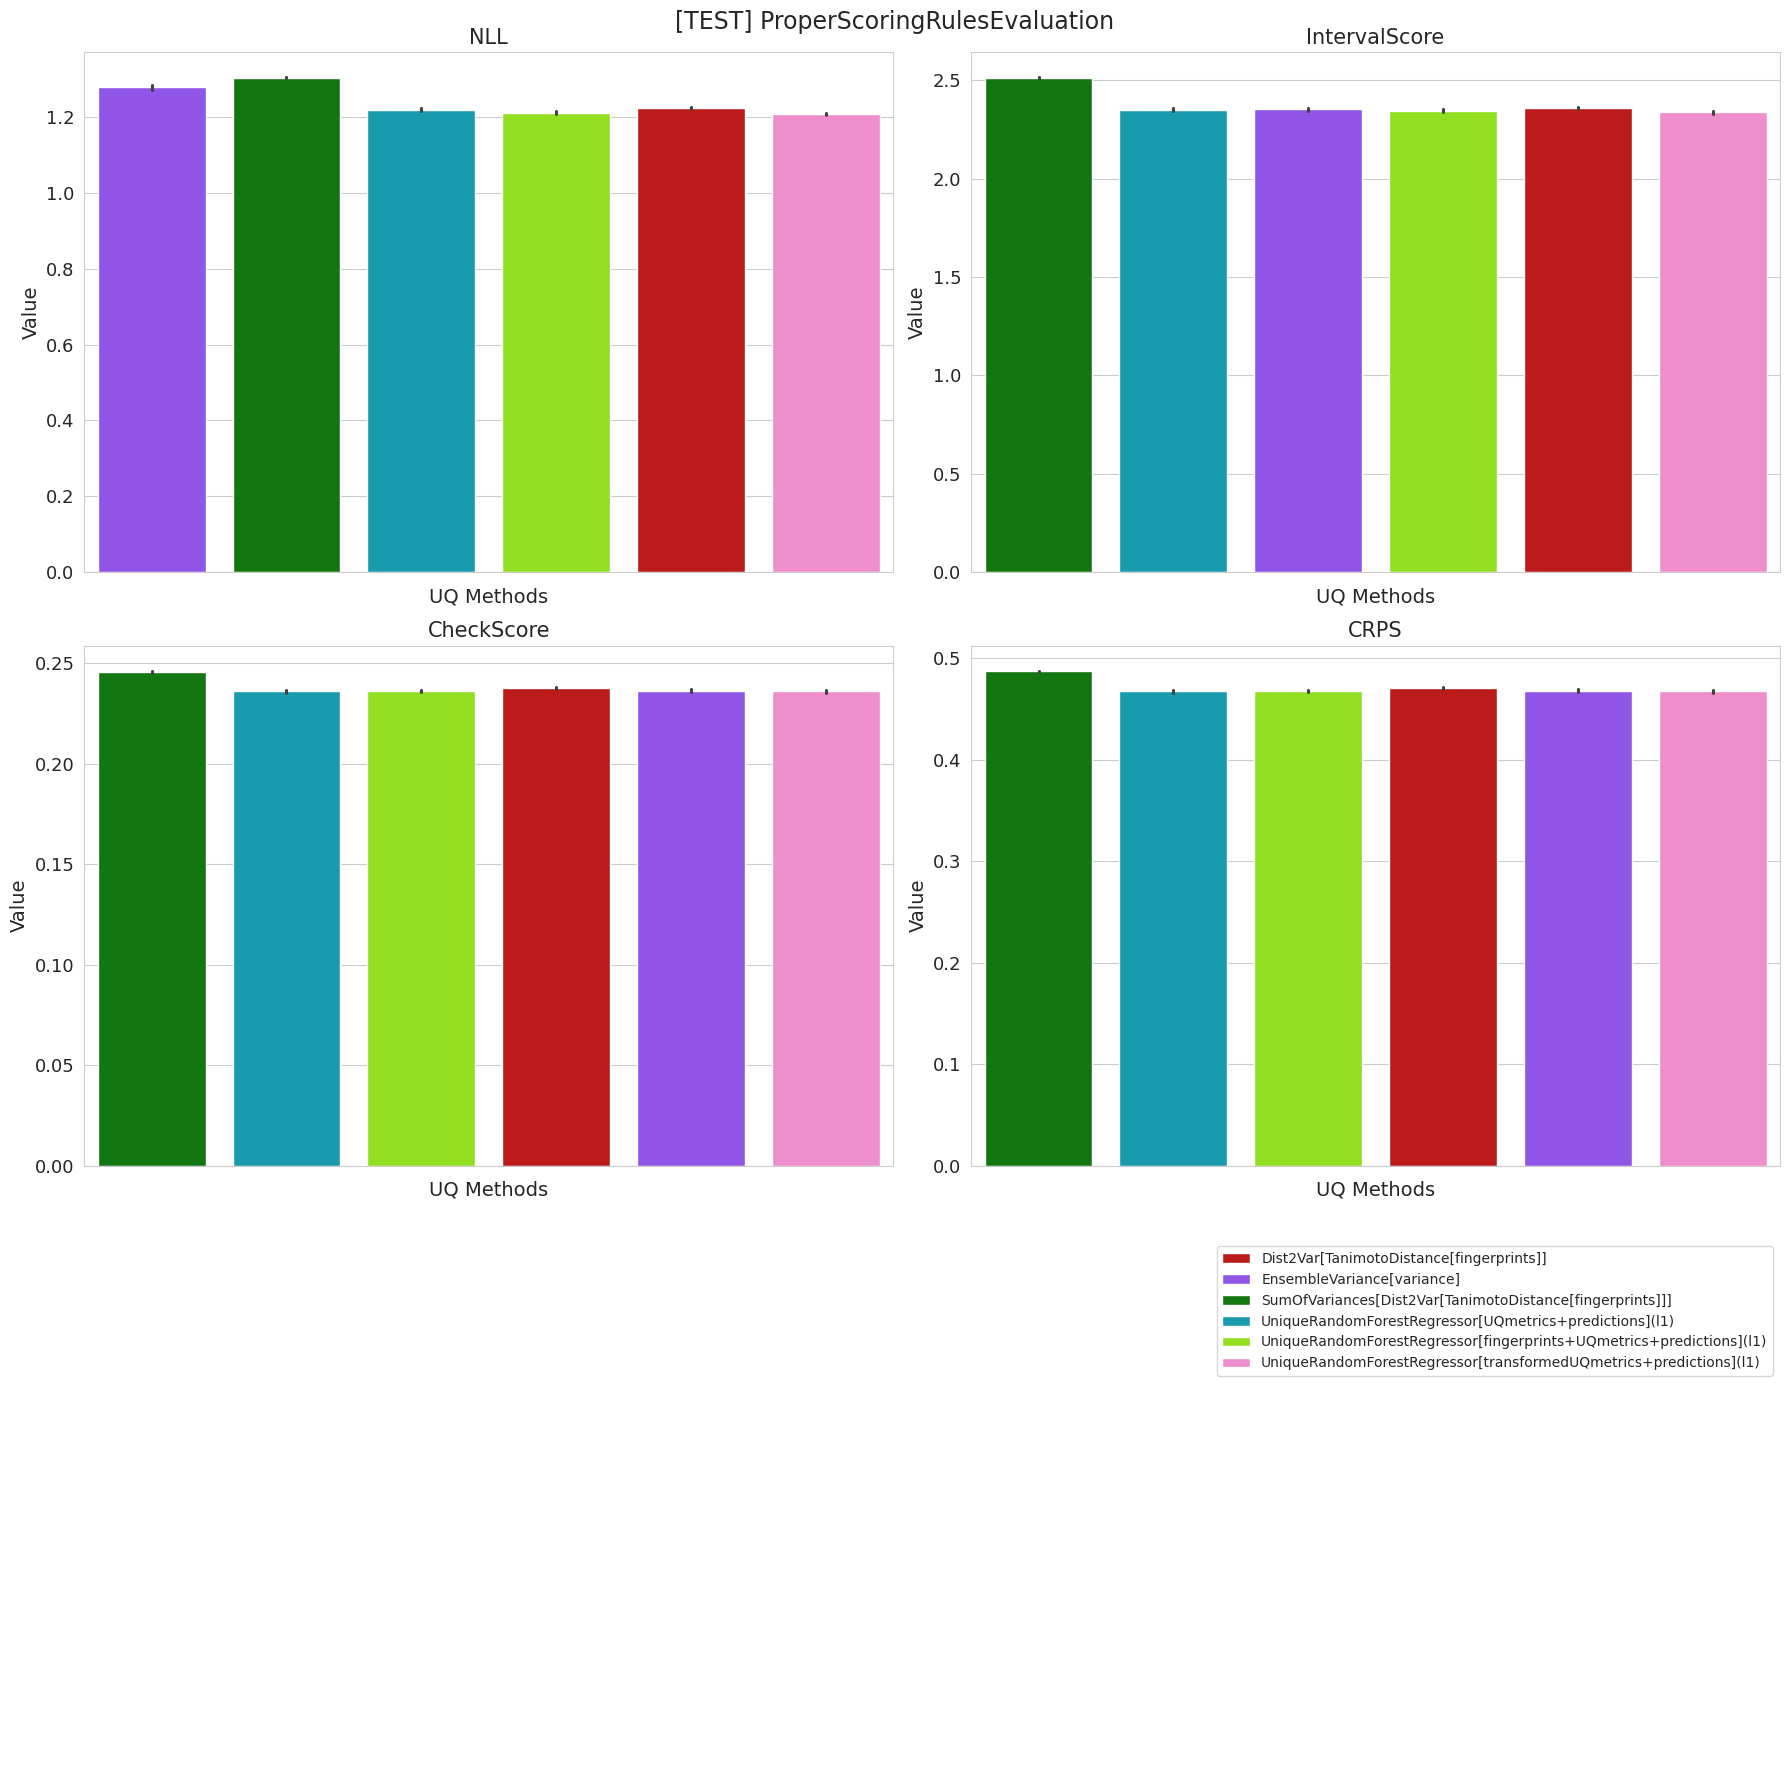

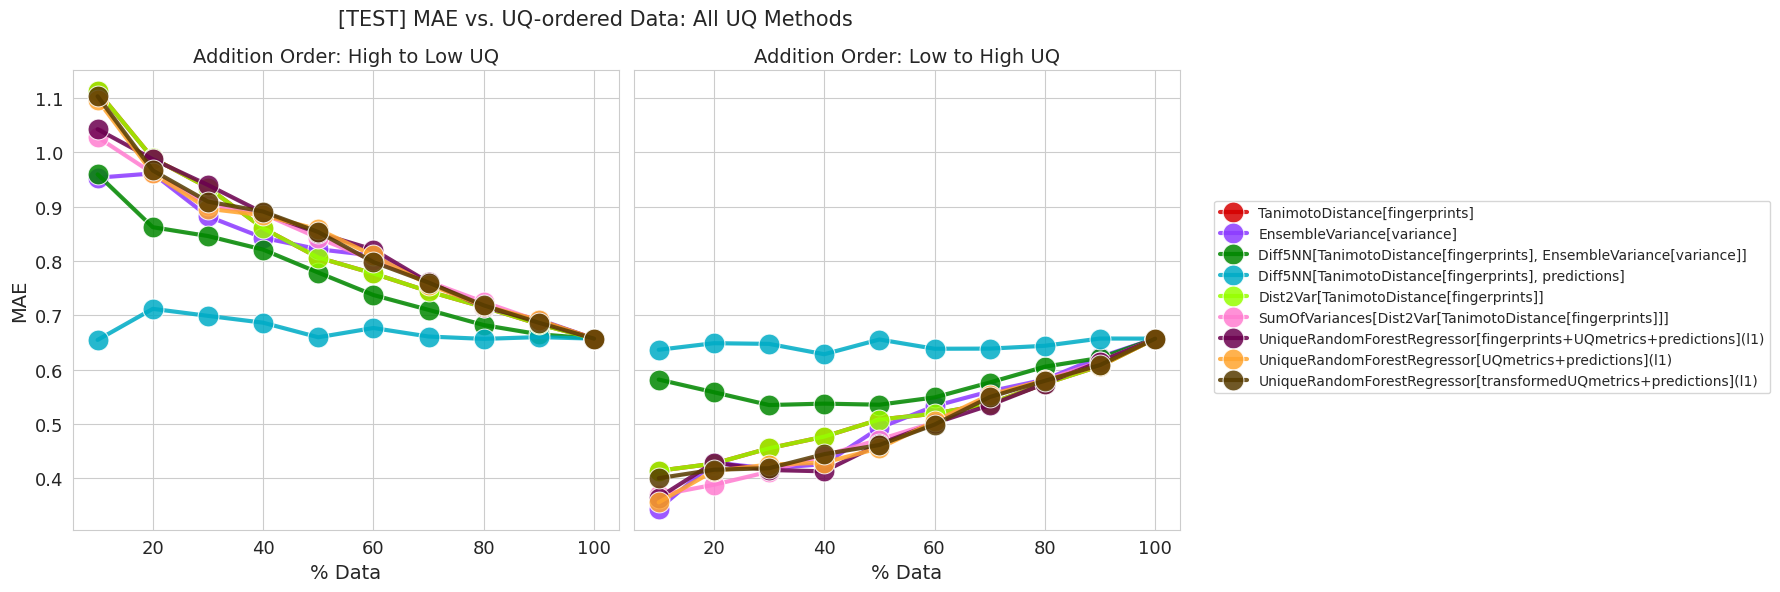

In [15]:
config_file = f'{PROJECT_PATH}/notebooks/LogD_public/logD_RFmfp_unique_input_config.yaml'

# Replace `data_path` and `output_path` to be able run the notebook automatically
# overwrite_paths(config_file, PROJECT_PATH) # COMMENT TO DISABLE OVERWRITING

pipeline = Pipeline.from_config(config_file)

# Compute UQ metrics, train error models (if any), evaluate UQ metrics
output, eval_results = pipeline.fit()

In [16]:
# Optionally save the computed UQ metrics
pd.DataFrame.from_dict(output).to_csv(pipeline.output_path / "uq_metrics_values.csv", index=False)

# `eval_results` is a dict containing the evaluation data used to generate the plots